### BASE DE DATOS DE SPOTIFY

---

##### Trabajo practico I - Analisis predictivo avanzado
##### *Análisis exploratorio de datos*

### PASO 1: Importar librerias

In [ ]:
!pip install feature_engine
!pip install langdetect
!pip install feature-engine
!pip install genderize

In [ ]:
import pandas as pd
import requests
import warnings
import openpyxl
import datetime
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from langdetect import detect
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import FunctionTransformer
from collections import defaultdict
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import auc, RocCurveDisplay
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.colors as mcolors
import pandas as pd
from pandas.plotting import scatter_matrix

### PASO 2: cargar el DF

In [ ]:
# CARGAMOS EL DATASET #
df = pd.read_csv('train_spotify.csv')

# ELIMINAMOS LA COLUMNA 0 YA Q NO ES RELEVANTE A NUESTRO ANALISIS #
df = df.drop(df.columns[0], axis=1)

### PASO 3: analisis de la base (EDA)

##### Analisis general de filas y columnas

In [ ]:
num_filas, num_columnas = df.shape
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)

Cantidad de filas: 129172
Cantidad de columnas: 17


In [ ]:
columnas_categoricas= df.select_dtypes(include=['object'])
columnas_binarias = []

for columna in df.columns:
    if df[columna].isin([0, 1, True, False, np.nan]).all():
        columnas_binarias.append(columna)

columnas_numericas = df.select_dtypes(exclude=['object']).drop(columns=['mode', 'explicit'])

print("Tipos de columnas:")
print("Categoricas:",columnas_categoricas.columns)
print("Binarias",columnas_binarias)
print("Numericas",columnas_numericas.columns)

Tipos de columnas:
Categoricas: Index(['artists', 'name'], dtype='object')
Binarias ['explicit', 'mode']
Numericas Index(['year', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity'],
      dtype='object')


##### Columnas categoricas

In [ ]:
# VALORES UNICOS EN COLUMNAS CATEGORICAS #
cantidad_valores_unicos = columnas_categoricas.nunique()
cantidad_valores_unicos

artists     30429
name       106371
dtype: int64

In [ ]:
# VALORES NULOS #
cantidad_nulos_categoricas = columnas_categoricas.isnull().sum()
cantidad_nulos_categoricas

artists    0
name       0
dtype: int64

In [ ]:
# FRECUENCIA DE LOS ARTISTAS #
frecuencias_artistas = df['artists'].value_counts().reset_index()
frecuencias_artistas.columns = ['artists', 'Frecuencia']
frecuencias_artistas = frecuencias_artistas.sort_values(by='Frecuencia', ascending=False)
frecuencias_artistas

,artists,Frecuencia
0,['Tadeusz Dolega Mostowicz'],952
1,['Эрнест Хемингуэй'],879
2,['Эрих Мария Ремарк'],808
3,['Francisco Canaro'],712
4,['Ignacio Corsini'],467
...,...,...
17930,"['John Askew', 'Activa']",1
17929,['Thomas Datt'],1
17928,['Graham Gold'],1
17927,"['Vicky Devine', 'Paul Miller']",1


##### Columnas binarias

In [ ]:
tabla_frecuencia_explicit = df['explicit'].value_counts().reset_index()
tabla_frecuencia_explicit.columns = ["explicit", "Frecuencia"]
tabla_frecuencia_explicit

,explicit,Frecuencia
0,0,120394
1,1,8778


In [ ]:
tabla_frecuencia_mode = df['mode'].value_counts().reset_index()
tabla_frecuencia_mode.columns = ["mode", "Frecuencia"]
tabla_frecuencia_mode

,mode,Frecuencia
0,1,90920
1,0,38252


##### Columnas numericas

In [ ]:
# VALORES NULOS #
cantidad_nulos_numericas= columnas_numericas.isnull().sum()
cantidad_nulos_numericas

year                0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
dtype: int64

In [ ]:
# OUTLIERS #
stats = columnas_numericas.describe()
Q1 = stats.loc['25%']
Q3 = stats.loc['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Outliers de cada variable:")
outliers = ((columnas_numericas < lower_bound) | (columnas_numericas > upper_bound))
outlier_counts = outliers.sum()
outlier_counts

Outliers de cada variable:


year                    0
acousticness            0
danceability           96
duration_ms          7393
energy                  0
instrumentalness    24635
key                     0
liveness             9275
loudness             2465
speechiness         18159
tempo                1327
valence                 0
popularity              0
dtype: int64

In [ ]:
# ESTADISTICOS DESCRIPTIVOS #
estadisticas_descriptivas = columnas_numericas.describe()
estadisticas_descriptivas

,year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,popularity
count,129172.000000,129172.000000,129172.000000,1.291720e+05,129172.000000,129172.000000,129172.000000,129172.000000,129172.000000,129172.000000,129172.000000,129172.000000,129172.000000
mean,1976.579762,0.501950,0.536076,2.328895e+05,0.481096,0.194286,5.207050,0.211519,-11.767025,0.105871,116.943154,0.525167,25.915539
std,26.722407,0.379088,0.175803,1.492669e+05,0.271778,0.332443,3.516778,0.180989,5.679598,0.182878,30.348323,0.264451,21.876377
min,1920.000000,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,1955.000000,0.091800,0.414000,1.662930e+05,0.248000,0.000000,2.000000,0.099300,-14.905000,0.035100,93.755500,0.311000,1.000000
50%,1977.000000,0.523000,0.547000,2.056665e+05,0.463000,0.000482,5.000000,0.138000,-10.868000,0.045400,115.639500,0.537000,26.000000
75%,1998.000000,0.895000,0.668000,2.658400e+05,0.707000,0.234000,8.000000,0.270000,-7.532000,0.076300,135.014000,0.744000,42.000000
max,2021.000000,0.996000,0.988000,5.338302e+06,1.000000,1.000000,11.000000,1.000000,3.855000,0.971000,243.507000,1.000000,96.000000


### PASO 4: graficos

#### Variables categoricas

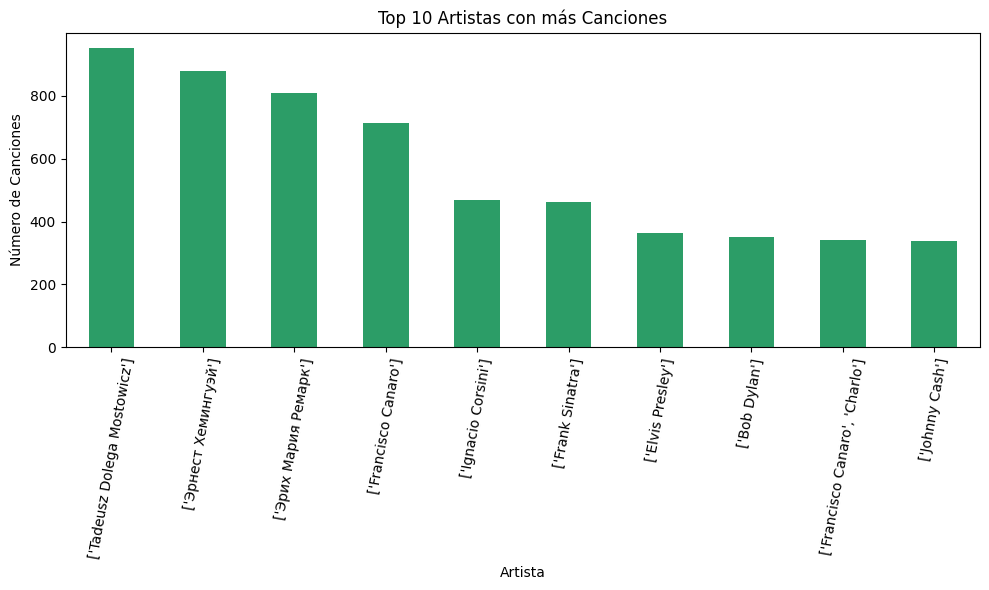

In [ ]:
# GRAFICO DE FRECUENCIA DE LOS ARTISTAS #
top_10_artistas = df['artists'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_10_artistas.plot(kind='bar', color='#2C9D67')
plt.title('Top 10 Artistas con más Canciones')
plt.xlabel('Artista')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=80)
plt.tight_layout()

# Mostrar el histograma
plt.show()

#### Variables numericas

##### BoxPlots e histogramas de las variables numericas

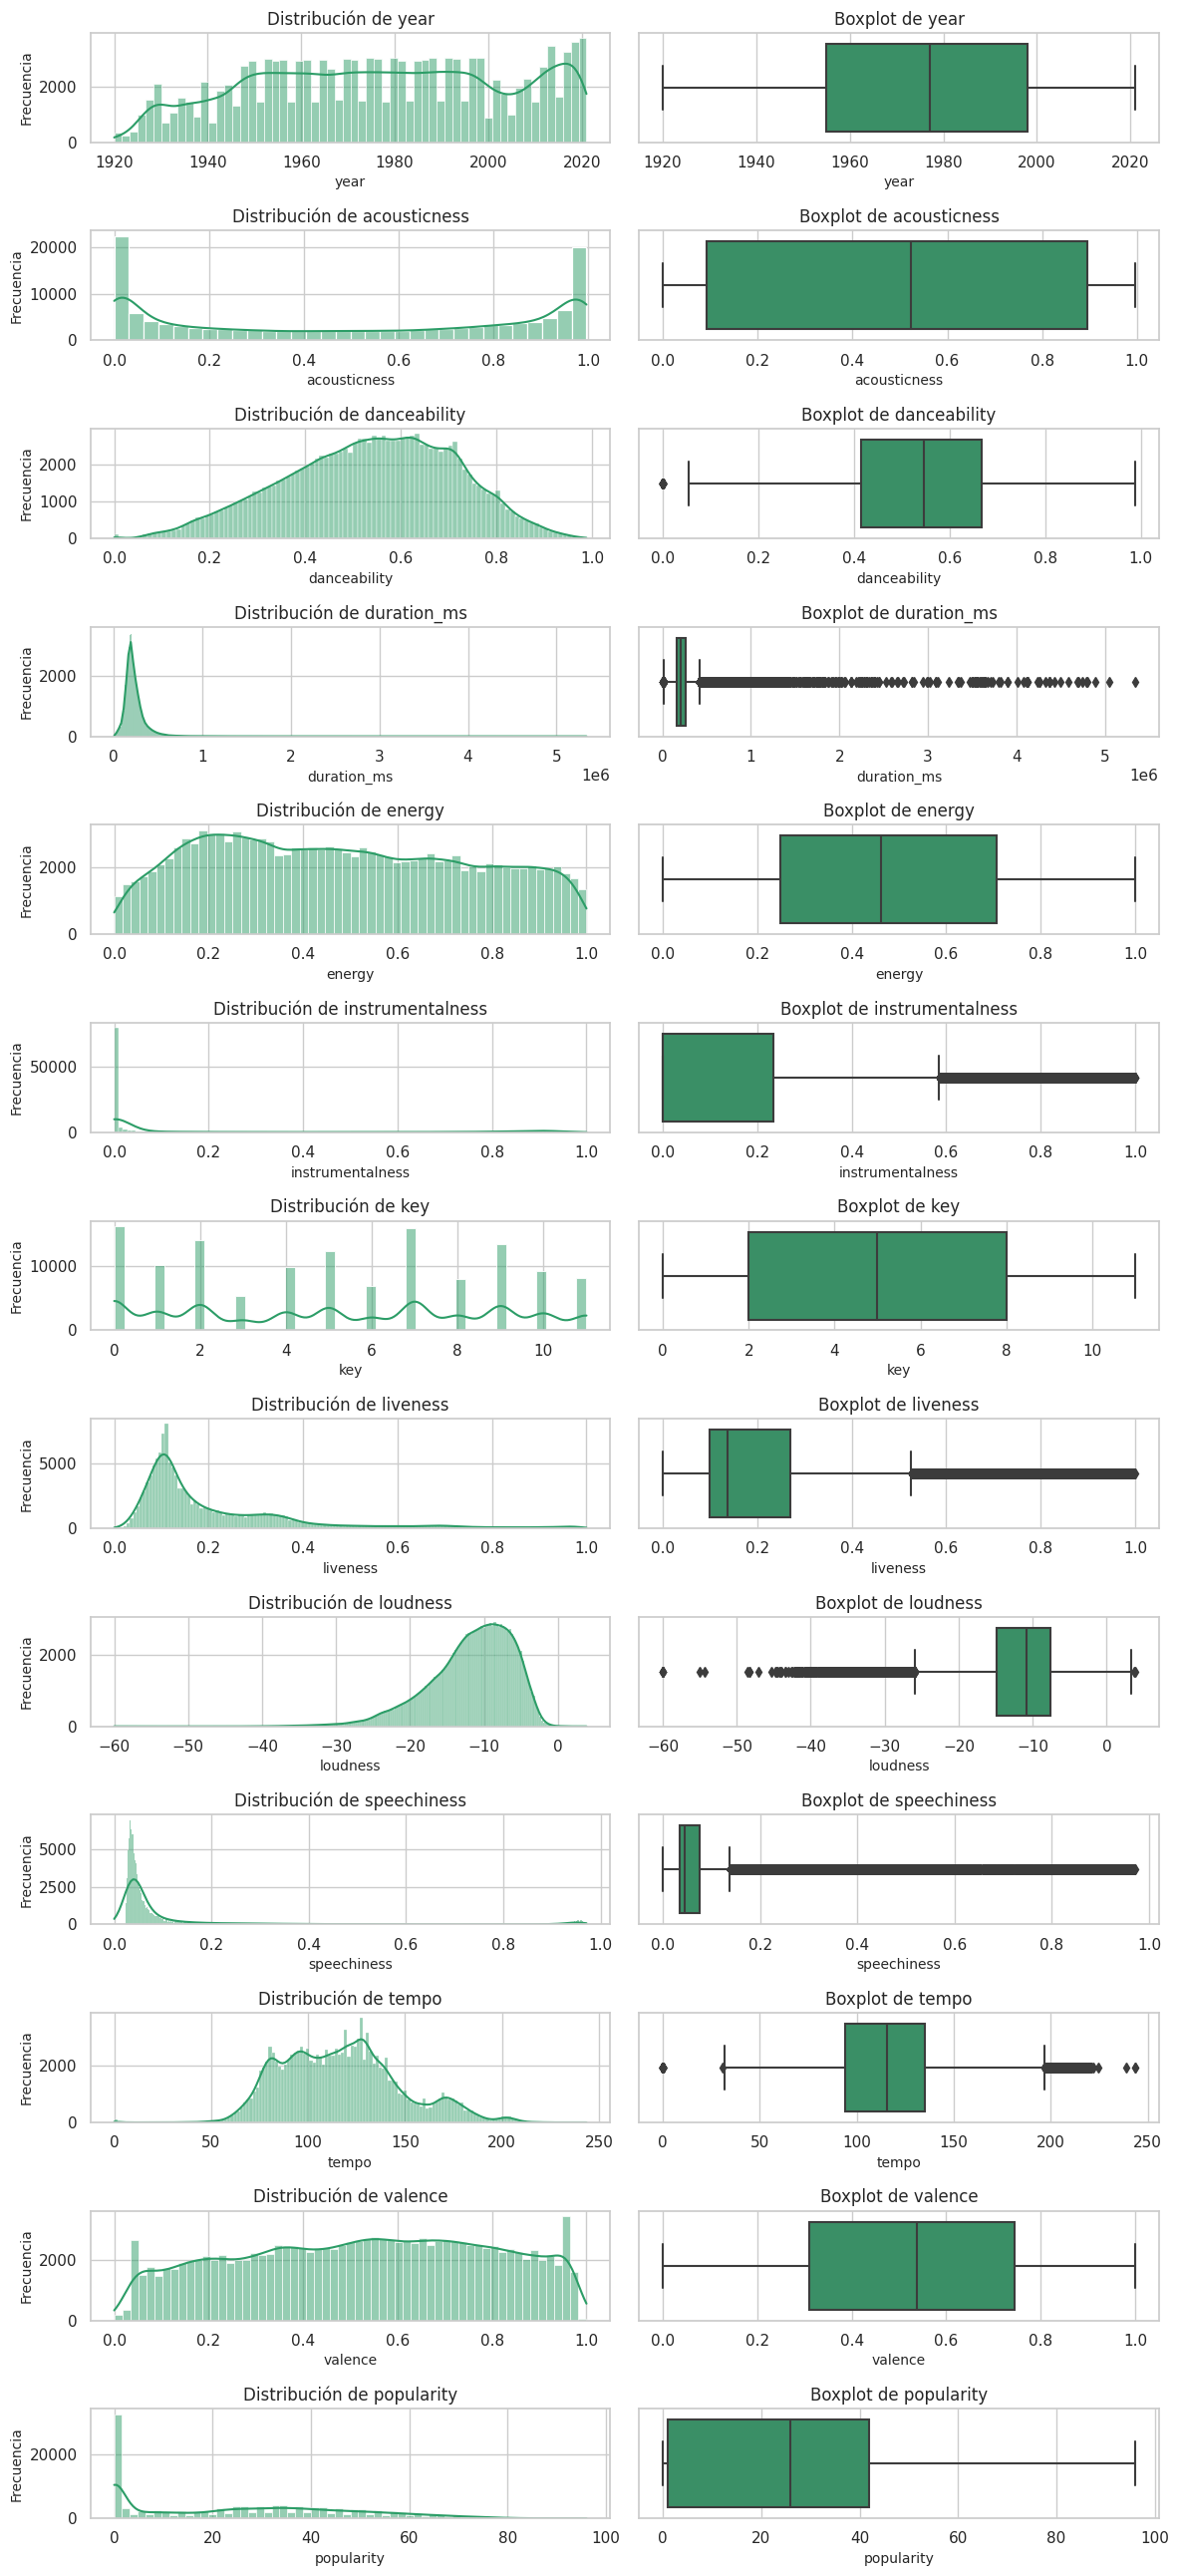

In [ ]:
sns.set(style="whitegrid", palette="deep")

# Crear subplots para los gráficos
fig, axes = plt.subplots(nrows=len(columnas_numericas.columns), ncols=2, figsize=(12, 2 * len(columnas_numericas.columns)))

# Iterar a través de las columnas numéricas
for i, columna in enumerate(columnas_numericas.columns):
    # Gráfico de distribución
    sns.histplot(data=df, x=columna, color='#2C9D67', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {columna}', fontsize=12)
    axes[i, 0].set_xlabel(columna, fontsize=10)
    axes[i, 0].set_ylabel('Frecuencia', fontsize=10)

    # Boxplot
    sns.boxplot(data=df, x=columna, color='#2C9D67', ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {columna}', fontsize=12)
    axes[i, 1].set_xlabel(columna, fontsize=10)

# Ajustar la disposición de los gráficos
plt.tight_layout()
plt.show()

##### Heatmap para ver relaciones entre variables numericas

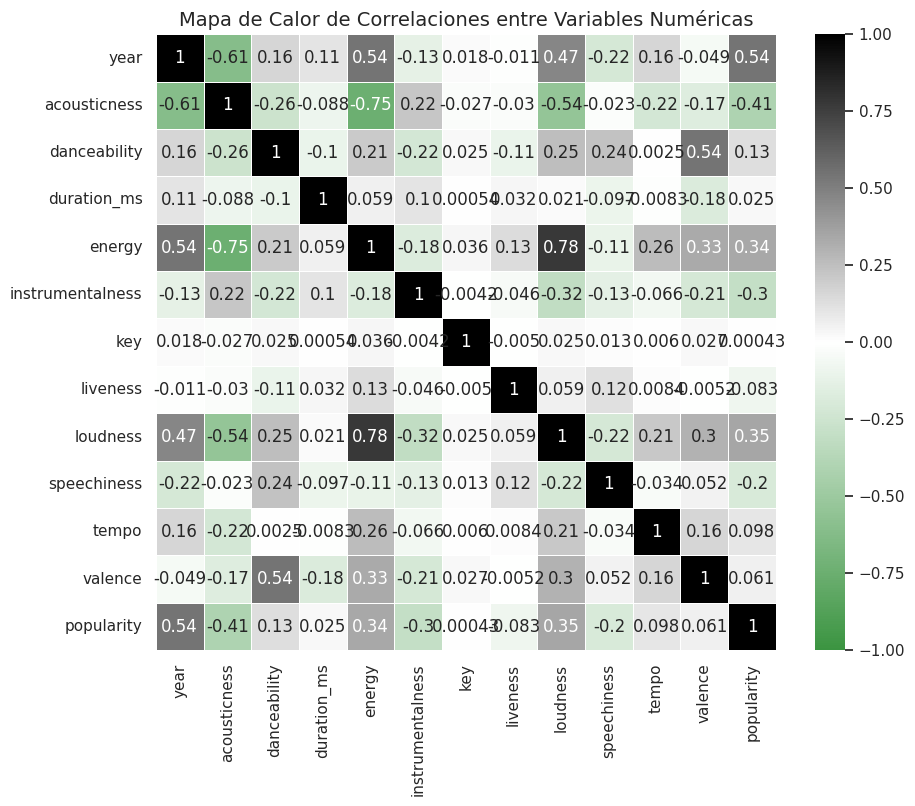

In [ ]:
color_inicio = "#3B9441"
color_fin = "#000000"

rgb_inicio = tuple(int(color_inicio.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_fin = tuple(int(color_fin.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))

mi_paleta_personalizada = mcolors.LinearSegmentedColormap.from_list("mi_paleta", [color_inicio, "#FFFFFF", color_fin])
matriz_correlacion = columnas_numericas.corr()

plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
sns.set_style("whitegrid")

sns.heatmap(matriz_correlacion, annot=True, cmap=mi_paleta_personalizada, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones entre Variables Numéricas', fontsize=14)

plt.show()

##### Scatermatrix (chquear esto, queda rara)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:97: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


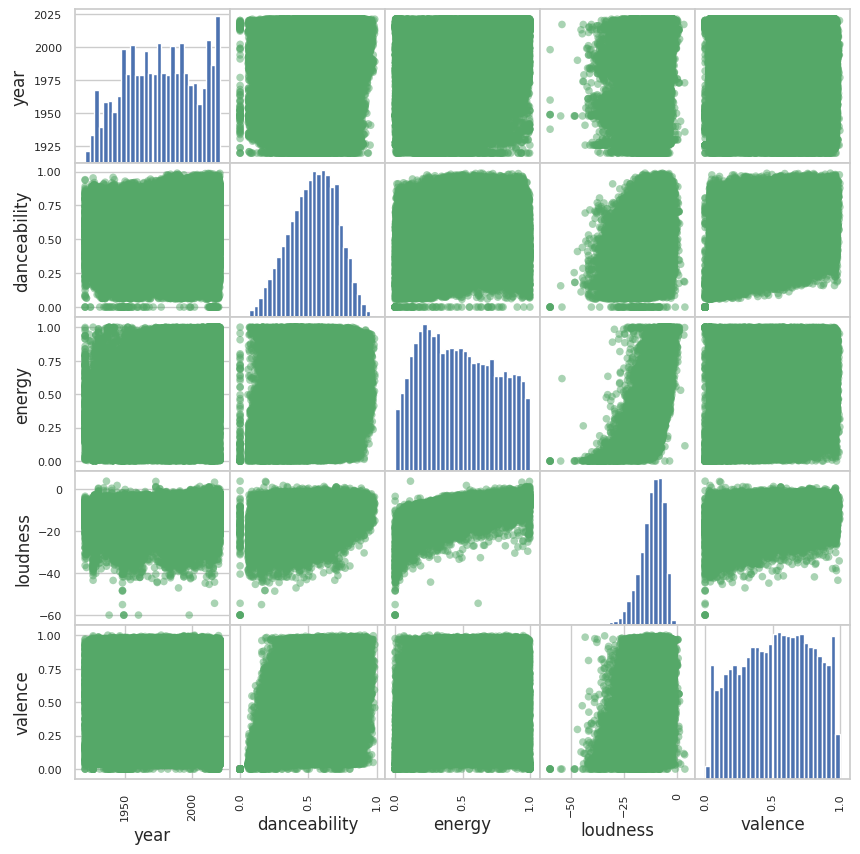

In [ ]:
bm = df.columns.isin(['energy', "loudness", "danceability", "valence", "year"])
sc = df.columns[bm]
data = df[sc]

# Aumenta la separación entre los ejes X e Y y ajusta el tamaño de los puntos
scatter_matrix(data, alpha=0.5, figsize=(10, 10),
               marker='o', hist_kwds={'bins': 30}, s=30,
               range_padding=0.15, cmap=plt.cm.brg, diagonal='hist', color="g")

plt.show()

##### Funcion para armar scaterplot

In [ ]:
def scatter_plot(x, y, x_label="Variable X", y_label="Variable Y"):
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

    # Scatter plot con colores personalizados y transparencia
    plt.scatter(x, y, alpha=0.7, c='green', label='Datos')

    # Añadir una leyenda
    plt.legend()

    # Personalizar el título y etiquetas de los ejes
    plt.title("Scatter Plot")
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Aumentar el espacio entre los ejes X e Y
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Mostrar la cuadrícula
    plt.grid(True)

    # Mostrar el gráfico
    plt.show()

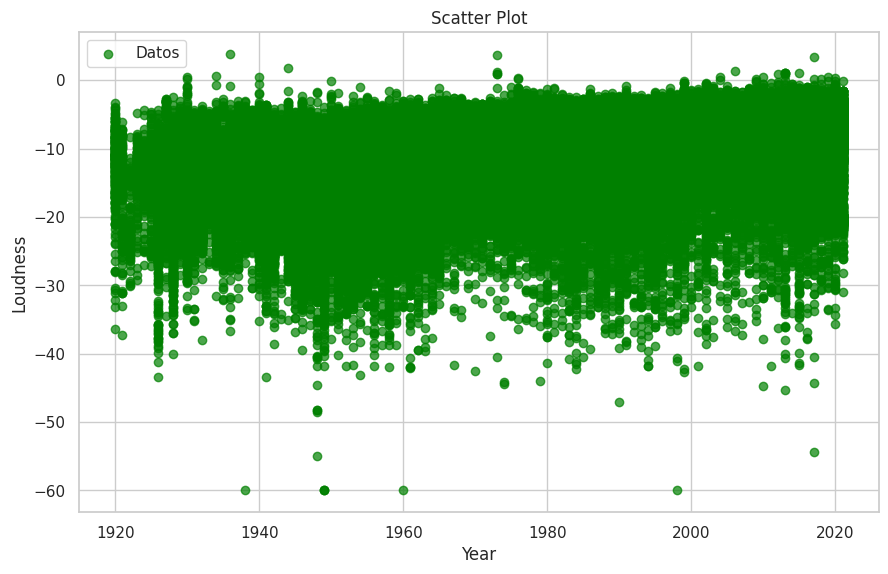

In [ ]:
# SCATTER PLOT ENTRE YEAR Y LOUDNESS #
y_values = df["loudness"]
x_values = df["year"]
scatter_plot(x_values, y_values, x_label="Year", y_label="Loudness")

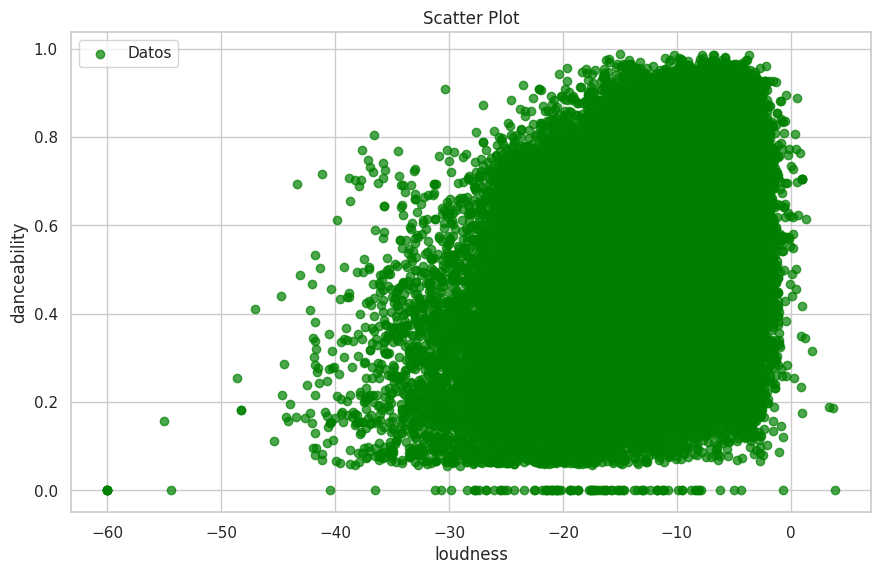

In [ ]:
# SCATTER PLOT ENTRE YEAR Y LOUDNESS #
y_values = df["danceability"]
x_values = df["loudness"]
scatter_plot(x_values, y_values, x_label="loudness", y_label="danceability")